# Fairness Analysis

In [36]:
import torch

import numpy as np
import pandas as pd
import tqdm

from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

from src.data.dataloader import CatalanJuvenileJustice
from src.models.model import FullyConnected, AutoEncoder

In [37]:
def set_seed(seed: int):
    torch.manual_seed(seed)

plt.style.use('ggplot')

In [38]:
DATA_DIR    = "../../data" 
MODEL_DIR   = "../../models"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
def load_model(experiment: dict):
    input_parameters = experiment['model']['input_parameters']

    if experiment['model']['name'] == 'AutoEncoder':
        model = AutoEncoder(channels_in=input_parameters[0], z_dim=input_parameters[1], channels_out=input_parameters[2])
        model.encoder = experiment['model']['net'][0]
        model.classifier = experiment['model']['net'][1]
        model.load_state_dict(experiment['state_dict'])
        return model
    
    elif experiment['model']['name'] == 'FullyConnected':
        model = FullyConnected(channels_in=input_parameters[0], channels_out=input_parameters[1])
        model.net = experiment['model']['net']
        model.load_state_dict(experiment['state_dict'])
        return model
    
    else:
        raise NotImplementedError("Yet to be implemented...")

### Model trained with access to sensitive attributes

In [40]:
experiment_name = 'temporary-AutoEncoder-sensitive_data'

experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")
experiment.keys()

dict_keys(['experiment_name', 'seed', 'model', 'input_parameters', 'training_parameters', 'data', 'best_epoch', 'state_dict'])

In [41]:
set_seed(experiment['seed'])

dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

_, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

In [42]:
# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=84, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [43]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


In [44]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [45]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7215053763440861


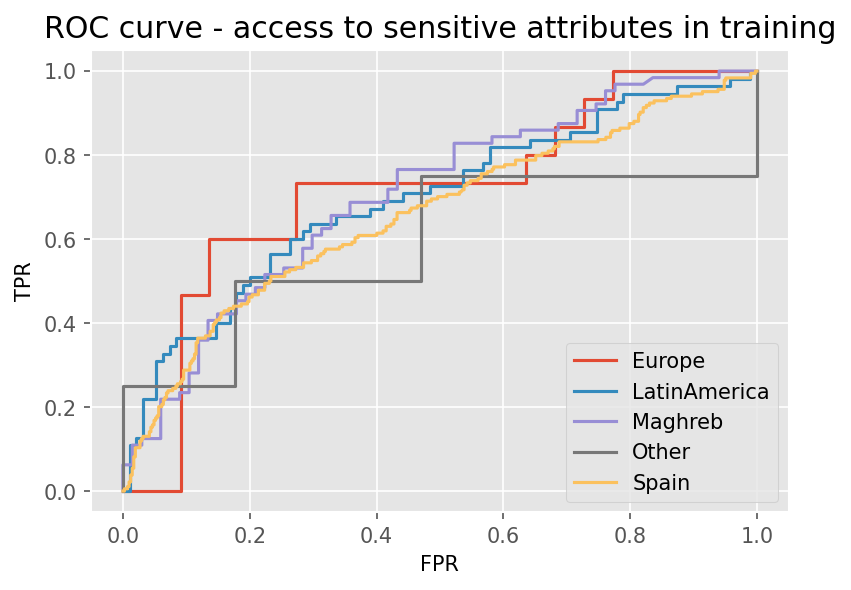

In [54]:
fairness_cols = df.iloc[:, ['area_origin' in column for column in df.columns]].columns

fig = plt.figure(figsize=(6, 4), dpi=150)
for i, col in enumerate(fairness_cols):
    
    # Call each category within the sensitive attribute of interest
    df_ = df.query(f"{col} == 1")

    # FPR and TPR
    fpr, tpr, threshold = roc_curve(
        df_['labels'],
        df_['pred_probs'],
    )
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=f"C{i}", label=col.split("_")[-1])

plt.title("ROC curve - access to sensitive attributes in training")
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Modelled trained without access to sensitive attributes

In [47]:
experiment_name = 'temporary-AutoEncoder-no_sensitive_data'

experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")
experiment.keys()

dict_keys(['experiment_name', 'seed', 'model', 'input_parameters', 'training_parameters', 'data', 'best_epoch', 'state_dict'])

In [48]:
set_seed(experiment['seed'])

dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

_, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

In [49]:
# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=73, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [50]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


In [51]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [52]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7010752688172043


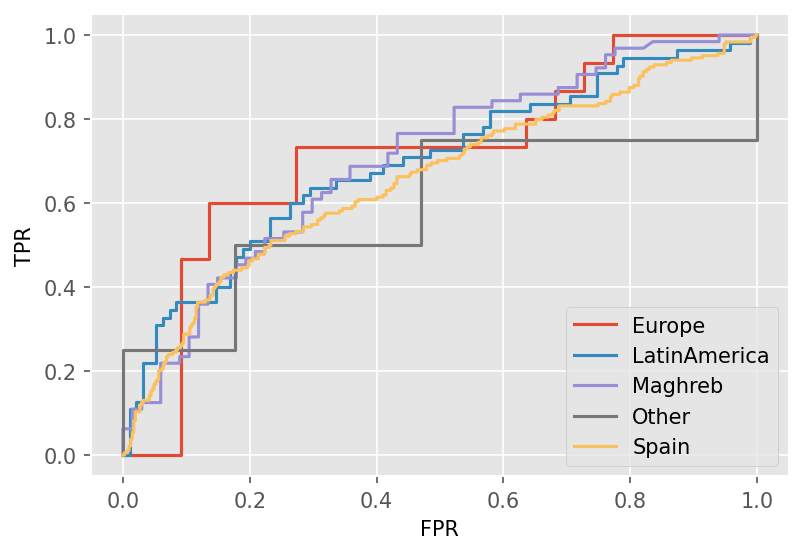

In [53]:
fairness_cols = df.iloc[:, ['area_origin' in column for column in df.columns]].columns

fig = plt.figure(figsize=(6, 4), dpi=150)
for i, col in enumerate(fairness_cols):
    
    # Call each category within the sensitive attribute of interest
    df_ = df.query(f"{col} == 1")

    # FPR and TPR
    fpr, tpr, threshold = roc_curve(
        df_['labels'],
        df_['pred_probs'],
    )
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=f"C{i}", label=col.split("_")[-1])

plt.title("ROC curve - access to sensitive attributes in training")
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()